In [1]:
from pyspark.sql import SparkSession
from urllib.request import urlretrieve
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("ADS project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.executor.memory","4G")
    .config("spark.driver.memory","8G")
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/08/22 01:35:41 WARN Utils: Your hostname, Luo resolves to a loopback address: 127.0.1.1; using 172.17.1.121 instead (on interface eth0)
22/08/22 01:35:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/22 01:35:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark.conf.set("spark.sql.parquet.compression.codec", "gzip")

In [3]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sbs
import geopandas as gpd
import folium

In [4]:
YEARS = ["2019"]
cols = ['trip_distance', 'fare_amount', 'average_speed', 'time_duration', 'tip_amount']

In [5]:
# add the features that we need for the analysis based on the some of original data attributes
def add_feature(sdf):
    return sdf.withColumn('Month,Date', date_format("tpep_pickup_datetime", "MM,dd"))\
        .withColumn('Month', date_format("tpep_pickup_datetime", "MM").cast('int'))\
        .withColumn('Pickup_time', date_format('tpep_pickup_datetime', 'HH').cast('int'))\
        .withColumn("time_duration", unix_timestamp('tpep_dropoff_datetime') - unix_timestamp('tpep_pickup_datetime'))\
        .withColumn("is_weekend", dayofweek("tpep_pickup_datetime").isin([1,7]).cast("int"))\
        .withColumn("average_speed", F.col('trip_distance') / (F.col('time_duration')/3600))\
        .withColumn('is_airport', (F.col('DOLocationID')==1) | (F.col('DOLocationID')==132) | (F.col('DOLocationID')==138)\
                | (F.col('PULocationID')==1) | (F.col('PULocationID')==132) | (F.col('PULocationID')==138))

In [6]:
# remove the data records that are invalid against common sense or business rule
def clean_feature(sdf):
    return sdf.where(F.col('time_duration') >= 60).where(F.col('tip_amount') > 0)\
            .where(F.col('trip_distance') > 0).where(F.col('payment_type') == 1)\
            .where(F.col('fare_amount') >= 2.5)

In [7]:
# sampling from the raw dataset to demonstrate visualisations
def sampling(sdf, year):  
    # take 0.1% of the raw dataset 
    SAMPLE_SIZE = 0.001
    cleaned_df = sdf.sample(SAMPLE_SIZE, seed=0).toPandas()
    cleaned_df.to_parquet(f'../data/curated/{year}_first_cleaned.parquet')
    cleaned_df = pd.read_parquet(f'../data/curated/{year}_first_cleaned.parquet')
    return cleaned_df

In [8]:
# make a quantile dataframe to store all quantiles for wac numeric feature
def create_quan_df():
    colu = cols
    inde = ['Q0', 'Q1', 'Q3', 'Q4', 'IQR']
    return pd.DataFrame(index = inde, columns = colu)

In [9]:
# make the boxplot for each numeric feature to observe the range of values
label = ['Trip Distance', 'Fare Amount', 'Average Speed', 'Time Duration', 'Tip Amount']
def box_plot(sdf, year, clean):
    # set 5 figures in a row
    fig, axs = plt.subplots(1, 5, figsize=(15,5))
    # one boxplot for each of the five attributes
    axs[0].boxplot(sdf[cols[0]])
    axs[0].set_xlabel(label[0], size = 16, font = 'New Times Roman')
    axs[1].boxplot(sdf[cols[1]])
    axs[1].set_xlabel(label[1], size = 16, font = 'New Times Roman')
    axs[2].boxplot(sdf[cols[2]])
    axs[2].set_xlabel(label[2], size = 16, font = 'New Times Roman')
    axs[3].boxplot(sdf[cols[3]])
    axs[3].set_xlabel(label[3], size = 16, font = 'New Times Roman')
    axs[4].boxplot(sdf[cols[4]])
    axs[4].set_xlabel(label[4], size = 16, font = 'New Times Roman')
    fig.suptitle(f"Boxplot for data in {year} after {clean} clean", fontsize=18)
    # store the plot
    plt.savefig(f"../plots/{year} boxplot {clean} clean")
    plt.show()
    

In [10]:
# calculate the quantiles for each feature, fill them into the quantile dataframe
def find_quantile(df, quan_df):
    # Find the quantiles for each feature in the cols
    Q0 = df[cols].quantile(0.05)
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    Q4 = df[cols].quantile(0.95)
    IQR = Q3 - Q1
    # fill the quantiles into a dataframe
    for fea in cols:    
        quan_df.loc["Q0", fea] = Q0[fea]
        quan_df.loc["Q1", fea] = Q1[fea]
        quan_df.loc["Q3", fea] = Q3[fea]
        quan_df.loc["Q4", fea] = Q4[fea]
        quan_df.loc["IQR", fea] = IQR[fea]
    return quan_df, Q1, Q3, IQR

In [11]:
# make a pair plot to observe the relationship between each feature and the response variable
def pair_plot(df, year):
    sbs.set(style="ticks", color_codes=True)
    g = sbs.pairplot(df[cols], plot_kws=dict(s=1, edgecolor="b", linewidth=1),)
    g.fig.suptitle(f"{year} Pair Plot", y = 1)
    # save the figure
    g.savefig(f"../plots/{year} Pair Plot")
    plt.show()

22/08/22 01:35:49 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


findfont: Font family ['New Times Roman'] not found. Falling back to DejaVu Sans.


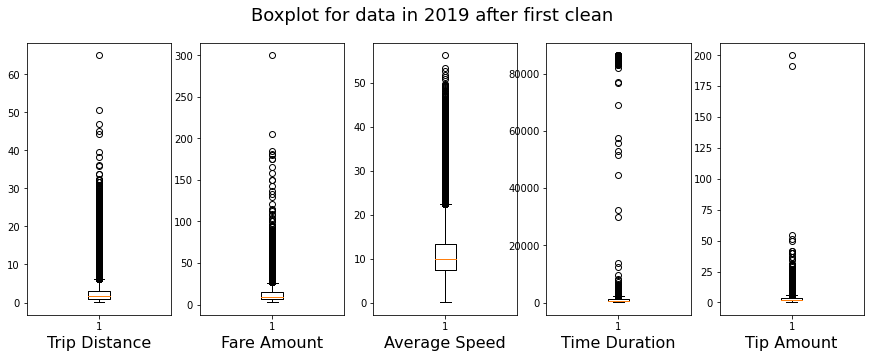

/tmp/ipykernel_11071/126051727.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_df["tip_rate"]=removed_df[["tip_amount","fare_amount"]].apply(lambda x:x["tip_amount"] / x["fare_amount"],axis=1)


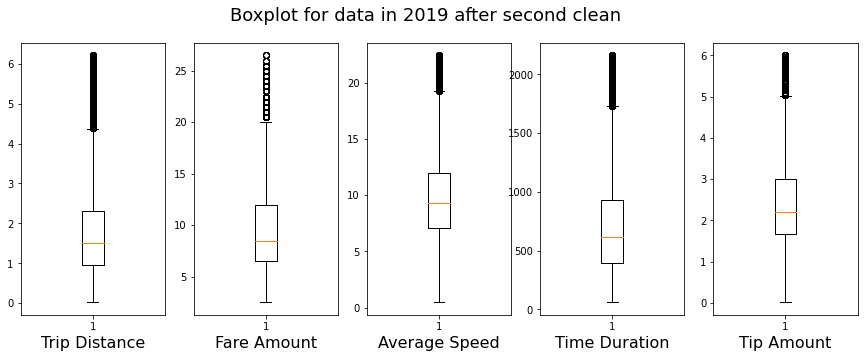

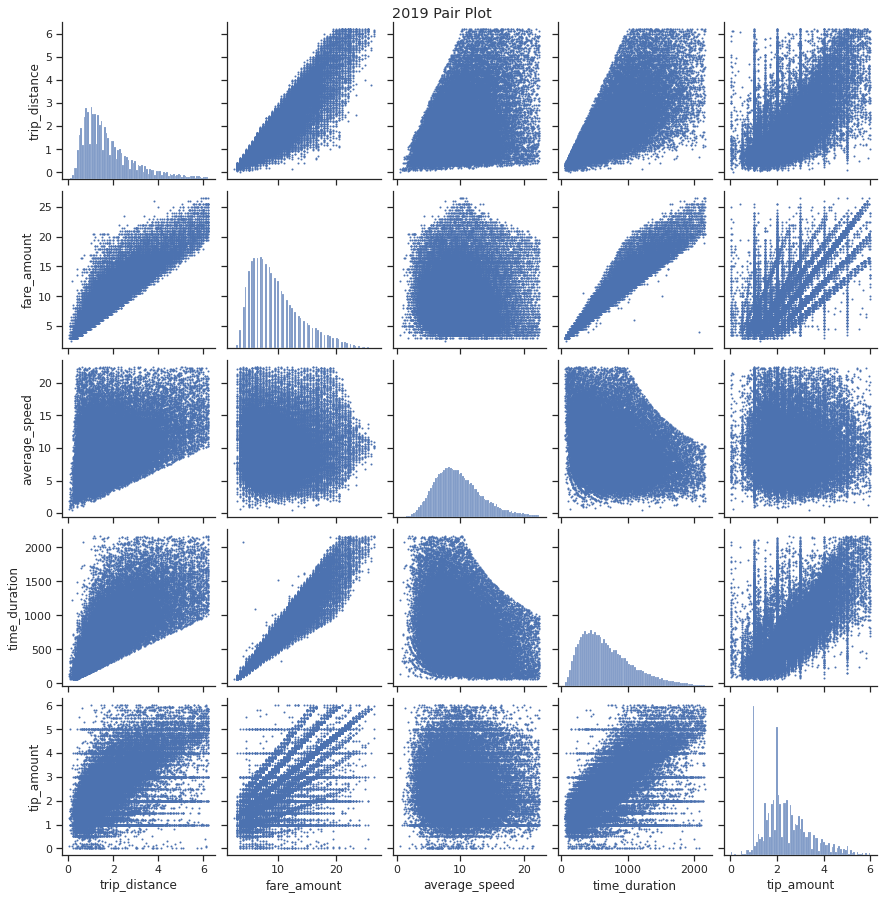

In [12]:
for year in YEARS:
    # read in the data of the same year as a whole
    sdf = spark.read.parquet(f'../data/raw/tlc_data/{year}')
    # repeat same cleaning steps as in 'First Clean.ipynb'
    sdf = clean_feature(add_feature(sdf))
    # make the sampling to prepare for visualisations
    cleaned_df = sampling(sdf, year)
    box_plot(cleaned_df, year, 'first')
    # find the quantiles of each feature
    quan_df = create_quan_df()
    quan_df, Q1, Q3, IQR = find_quantile(cleaned_df, quan_df)
    quan_df.to_csv(f'../data/{year}_quantile.csv')
    # remove everything 1.5*IQR outside of Q1 and Q3
    removed_df = cleaned_df[~((cleaned_df[cols] < (Q1 - 1.5*IQR)) | (cleaned_df[cols] > (Q3 + 1.5*IQR))).any(axis=1)]
    removed_df["tip_rate"]=removed_df[["tip_amount","fare_amount"]].apply(lambda x:x["tip_amount"] / x["fare_amount"],axis=1)
    # observe the datas left
    box_plot(removed_df, year, 'second')
    extra_col = cols.copy()
    extra_col.append("tip_rate")
    pair_plot(removed_df, year)
    

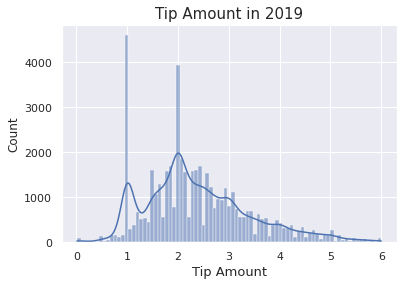

In [13]:
# observe the distribution of Tip amount
sbs.set_theme(style = 'darkgrid')
sbs.histplot(removed_df['tip_amount'], kde = True)
plt.title('Tip Amount in 2019', size = 15)
plt.xlabel('Tip Amount', size = 13)
plt.savefig("../plots/Tip Amount in 2019")
plt.show()